In [14]:
import sys
from pathlib import Path
import importlib
import random
import numpy as np

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

import src.topic_modeling as mod

importlib.reload(mod)

import pandas as pd

random.seed(50)
np.random.seed(50)

In [15]:
import sqlite3

PROCESSED_DIR = Path(ROOT) / "data" / "processed"
DB_CLEANED_PATH = PROCESSED_DIR / "sims4_cleaned.db"

print("DB path:", DB_CLEANED_PATH)
print("Exists?", DB_CLEANED_PATH.exists())

conn = sqlite3.connect(DB_CLEANED_PATH)

df = pd.read_sql_query("SELECT * FROM sarcasm_sentiment_per_post", conn)
display(df.head(5))

DB path: /Users/baderrezek/Desktop/Projects/Personal/sims4-sentiment-analysis/data/processed/sims4_cleaned.db
Exists? True


,negative_prob,neutral_prob,positive_prob,sarcasm_prob,negative_raw,neg_w_sarcasm,full_post,date,post_id
0,0.221770,0.611407,0.166823,0.071126,0.054947,0.059519,the cat is under the covers with her are you k...,2025-08-14 20:14:34+00:00,1mqbu8g
1,0.025228,0.075202,0.899570,0.048953,-0.874342,-0.841625,Welp. My 3 year old turned off my computer. Lo...,2025-08-20 03:09:47+00:00,1mv3jnz
2,0.007088,0.032331,0.960581,0.103234,-0.953493,-0.879188,I love everything about this ridiculously big ...,2025-08-18 20:20:44+00:00,1mtxbiy
3,0.355312,0.527494,0.117194,0.050018,0.238118,0.235379,Does this look like a strawberry roll shortcak...,2025-08-28 19:01:04+00:00,1n2l1np
4,0.020656,0.222478,0.756866,0.046406,-0.736209,-0.709362,I got tired of tracking down fruits and veg so...,2025-08-11 10:36:01+00:00,1mn9ghp


In [16]:
complaints = df.query("neg_w_sarcasm > 0.2")

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(complaints["full_post"].tolist(), batch_size=256, show_progress_bar=True)

Batches: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]


In [ ]:
from bertopic import BERTopic
from bertopic import BERTopic
from umap import UMAP
import hdbscan

# Fix seeds everywhere
umap_model = UMAP(random_state=50)  
hdbscan_model = hdbscan.HDBSCAN(random_state=50)  

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(complaints["full_post"].tolist(), embeddings)

# Inspect results
topic_model.get_topic_info().head(10)

2025-09-04 22:07:47,068 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


KeyboardInterrupt: 

In [ ]:
data = []
for topic in topic_model.get_topics().keys():
    docs = topic_model.get_representative_docs(topic, top_n=10)
    data.append({
        "Topic": topic,
        "Representative_Docs": docs
    })

topics_w_all_docs = pd.DataFrame(data)

In [ ]:

new_labels = {
    -1: "Outliers/unclustered",
    0: "Mod/CC Conflicts & Patch Breakage",
    1: "Build/Buy Mode Confusion & Limitations",
    2: "Baby/ Infant/ Toddler Gameplay Issues",
    3: "Weird or Unintended Gameplay Events",
    4: "Sims 5 Critiques & Franchise Uncertainty",
    5: "Save File Loss & Recovery Issues",
    6: "Core Gameplay Failures (Relationships, Weddings, Traits)",
    7: "CAS Representation & Customization Gaps",
    8: "Family & Child Gameplay Issues",
    9: "Infant/Toddler Gameplay Challenges"
}

topic_model.set_topic_labels(new_labels)

In [ ]:
display(topic_model.get_topic_info())

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,979,-1_to_the_and_in,Outliers/unclustered,"[to, the, and, in, my, sims, of, is, it, for]","[Bringing a whole new meaning to the term ""Pha..."
1,0,312,0_this_what_is_why,Mod/CC Conflicts & Patch Breakage,"[this, what, is, why, me, you, know, dont, jus...",[What is this in his head?:\nIve never seen th...
2,1,278,1_mods_game_it_my,Build/Buy Mode Confusion & Limitations,"[mods, game, it, my, the, to, and, update, but...",[!! possible fix for new sims update !!:\n(ski...
3,2,123,2_build_the_house_it,Baby/ Infant/ Toddler Gameplay Issues,"[build, the, house, it, roof, to, building, an...",[Ways to make renovation actual challenging ga...
4,3,105,3_toddler_baby_is_infant,Weird or Unintended Gameplay Events,"[toddler, baby, is, infant, up, toddlers, the,...",[Today I learnt that Science Babies are not re...
5,4,64,4_outfits_outfit_the_and,Sims 5 Critiques & Franchise Uncertainty,"[outfits, outfit, the, and, in, this, wear, on...",[Fairy sims not linking with disguise in CAS:\...
6,5,57,5_grim_vlad_reaper_him,Save File Loss & Recovery Issues,"[grim, vlad, reaper, him, the, his, he, in, to...",[Accidentally deleted Grim Reaper:\nHello. I r...
7,6,51,6_wedding_sims_they_my,"Core Gameplay Failures (Relationships, Wedding...","[wedding, sims, they, my, the, so, and, at, th...",[Lovestruck has been pissing me off.:\nThese r...
8,7,49,7_sim_my_is_catfished,CAS Representation & Customization Gaps,"[sim, my, is, catfished, got, just, negative, ...",[Is there any way to bring my sim to life?:\nH...
9,8,48,8_save_files_saves_gone,Family & Child Gameplay Issues,"[save, files, saves, gone, my, lost, all, and,...",[Computer broke down and I lost 8 years of gam...


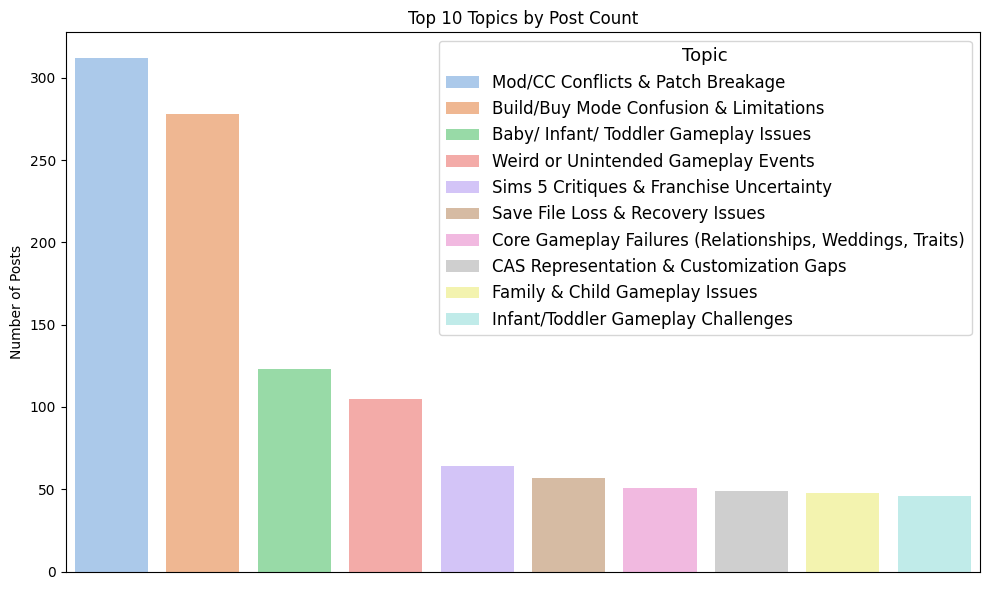

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

info = topic_model.get_topic_info()
counts = (info[info["Topic"] != -1][["CustomName","Count"]]
          .sort_values("Count", ascending=False)
          .head(10))

plt.figure(figsize=(10, 6))
sns.barplot(
    data=counts,
    x=counts.index,   # still needed for grouping
    y="Count",
    hue="CustomName",  # use the topic name as hue to get separate colors
    dodge=False,       # so bars don’t split
    palette="pastel"
)

# Remove x-axis labels (they overlap badly with long names)
plt.xticks([])
plt.xlabel("")

# Title and y-label
plt.title("Top 10 Topics by Post Count")
plt.ylabel("Number of Posts")

# Put legend in top right
plt.legend(
    title="Topic",
    loc="upper right",   
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout()
plt.show()